### Цель работы:

изучение алгоритмов и методов кластеризации на практике.
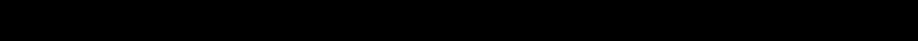
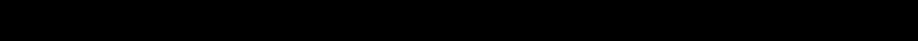

### Порядок выполнения работы:

1. Использовать функцию для создания набора данных
2. Получить с помощью функции набор данных
3. Провести стандартизацию данных
4. С помощью метода .fit_predict обучить модель для кластеризации методом Kmeans для трёх кластеров. Выполнить предсказание. Получить метки кластеров.
5. Провести визуализацию кластеров с помощью scatter. Построить графики. Пометить
на графике центры кластеров. Покрасить объекты из разных кластеров разными
цветами.
6. Посчитать коэффициент силуэта.
7. Повторить пункты 4-6 для n_clusters = 2 и n_clusters = 4 . Сравнить результаты и сделать
выводы.
8. Построить график по “методу локтя” и сделать выводы
9. Выполнить кластеризацию по вариантам

### Вариант задания - 3


Набор данных

_ecommerce_fraud.csv_

Данные содержат информацию о мошеннических транзакциях:
* transaction_amount — сумма транзакции, USD, числовой (логнормальное
распределение, возможны крупные суммы).
* device_type — тип устройства: Desktop / Mobile / Tablet, категориальный.
* browser — браузер: Chrome / Safari / Firefox / Edge / Other, категориальный.
* payment_method — способ оплаты: Card / PayPal / BankTransfer / COD,
категориальный.
* country — страна покупателя: US / UK / DE / FR / IN / BR / CN / Other,
категориальный.
* num_items — количество товаров в заказе, целочисленный (1–7).
* time_on_site_sec — время на сайте до покупки, секунды, числовой.
* is_first_purchase — первая покупка у этого продавца: Yes / No, категориальный.
* referral — источник трафика: Direct / Search / Social / Ads, категориальный.
* hour_of_day — час суток оформления заказа (0–23), целочисленный.
* account_age_days — «возраст» аккаунта, в днях, числовой.
* Fraud — целевой класс: 1 — мошенническая транзакция, 0 — нормальная


---

### Загрузка данных

Первым делом импортируем все необходимые для выполнения работы библиотеки, а именно:

pandas — для работы с табличными данными

numpy — для математических операций и работы с массивами

matplotlib и seaborn — для визуализации данных

sklearn — для алгоритмов машинного обучения и метрик

scipy — для иерархической кластеризации

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, fowlkes_mallows_score

from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

Была выполнена загрузка датасета для кластеризации из файла 'ecommerce_fraud.csv'. Датасет содержит 3000 строк.

In [93]:
df = pd.read_csv('ecommerce_fraud.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_amount  3024 non-null   float64
 1   device_type         3024 non-null   object 
 2   browser             3024 non-null   object 
 3   payment_method      3024 non-null   object 
 4   country             3024 non-null   object 
 5   num_items           3024 non-null   int64  
 6   time_on_site_sec    3024 non-null   float64
 7   is_first_purchase   3024 non-null   object 
 8   referral            3024 non-null   object 
 9   hour_of_day         3024 non-null   int64  
 10  account_age_days    3024 non-null   int64  
 11  Fraud               3024 non-null   int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 283.6+ KB


---

### 1. Предобработка данных

В датасете нет пропущенных значений.

In [94]:
df.isnull().sum()

transaction_amount    0
device_type           0
browser               0
payment_method        0
country               0
num_items             0
time_on_site_sec      0
is_first_purchase     0
referral              0
hour_of_day           0
account_age_days      0
Fraud                 0
dtype: int64

В датасете нет дубликатов.

In [95]:
df.duplicated().sum()

np.int64(0)

Все данные имеют правильный тип данных согласно описанию.

In [96]:
df.dtypes

transaction_amount    float64
device_type            object
browser                object
payment_method         object
country                object
num_items               int64
time_on_site_sec      float64
is_first_purchase      object
referral               object
hour_of_day             int64
account_age_days        int64
Fraud                   int64
dtype: object

Создан синтетический датасет из трёх кластеров по 50 точек каждый. Данные имеют явную групповую структуру, что видно на графике: три компактных скопления точек хорошо отделены друг от друга. Такой набор идеально подходит для проверки алгоритмов кластеризации.

In [97]:
n = 50  # количество точек в каждом кластере
seed = 42  # для воспроизводимости

np.random.seed(seed)

shift_matrix = np.array([[3, 3],
                         [6, 9],
                         [9, 3]])

data = np.random.randn(3, 2, n) + shift_matrix.reshape((3, 2, 1))

data = np.swapaxes(data, 1, 2)
data = data.reshape((-1, 2))

data *= np.array([[20, 0.5]])

df_synth = pd.DataFrame({'x': data[:, 0], 'y': data[:, 1]})
df_synth = df_synth.sample(frac=1.0, random_state=seed)

Получен синтетический набор данных, содержащий 150 объектов, распределённых в трёх чётко различимых кластерах. На графике видно три компактные группы точек вокруг красных звёзд (исходные центры кластеров). Данные идеально подходят для проверки алгоритмов кластеризации, так как имеют явную групповую структуру.

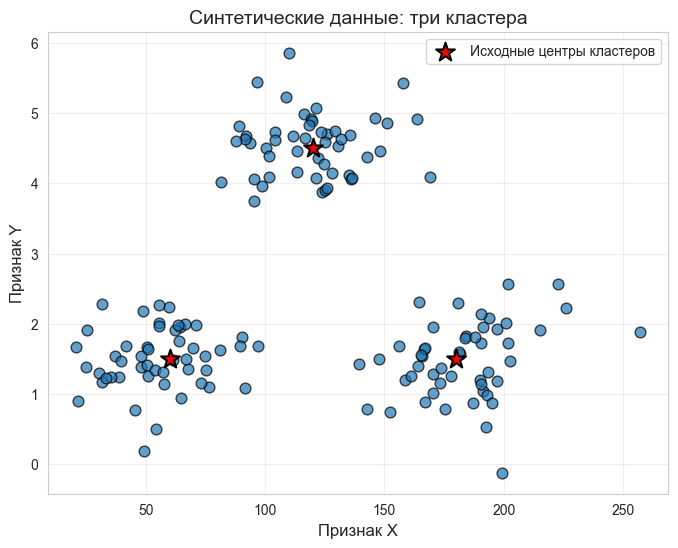

Общее количество точек: 150
Размерность данных: (150, 2)
Диапазон значений X: [20.8, 257.1]
Диапазон значений Y: [-0.1, 5.9]


In [98]:
# Визуализация полученного набора данных
plt.figure(figsize=(8, 6))
plt.scatter(df_synth['x'], df_synth['y'], alpha=0.7, edgecolors='k', s=60)
plt.title('Синтетические данные: три кластера', fontsize=14)
plt.xlabel('Признак X', fontsize=12)
plt.ylabel('Признак Y', fontsize=12)
plt.grid(True, alpha=0.3)

# Показываем центры исходных кластеров
centers = shift_matrix * np.array([[20, 0.5]])
plt.scatter(centers[:, 0], centers[:, 1], s=200, marker='*', color='red',
            label='Исходные центры кластеров', edgecolors='black', linewidth=1.5)
plt.legend()
plt.show()

# Основная информация о наборе данных
print(f"Общее количество точек: {len(df_synth)}")
print(f"Размерность данных: {df_synth.shape}")
print(f"Диапазон значений X: [{df_synth['x'].min():.1f}, {df_synth['x'].max():.1f}]")
print(f"Диапазон значений Y: [{df_synth['y'].min():.1f}, {df_synth['y'].max():.1f}]")

Данные успешно стандартизированы с помощью StandardScaler. После преобразования средние значения признаков близки к нулю, а стандартные отклонения — к единице. Это подтверждает корректность стандартизации. Форма и взаимное расположение кластеров сохранились, изменился только масштаб осей. Стандартизация необходима для корректной работы алгоритма K-means, который использует евклидово расстояние.

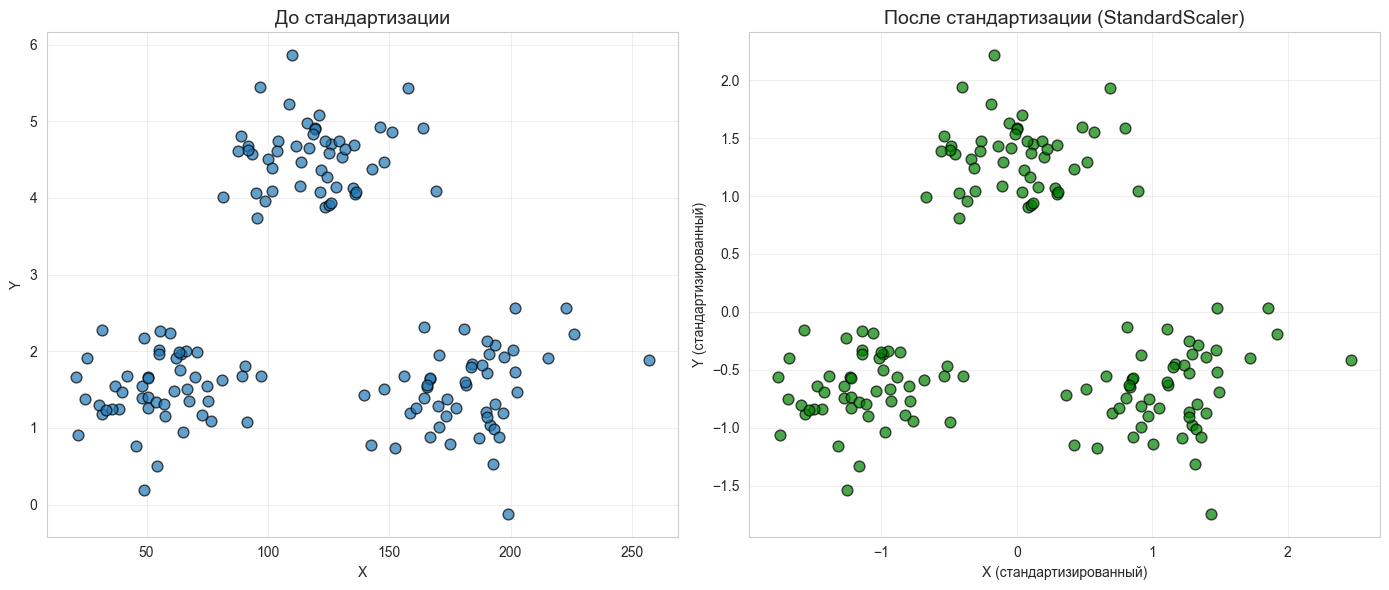

Проверка стандартизации:
Среднее X: -0.000000 (должно быть ~0)
Среднее Y: -0.000000 (должно быть ~0)
Стд. отклонение X: 1.003350 (должно быть ~1)
Стд. отклонение Y: 1.003350 (должно быть ~1)


In [99]:
# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_synth)

# Создаём DataFrame со стандартизированными данными
df_scaled = pd.DataFrame(X_scaled, columns=['x_scaled', 'y_scaled'])

# Визуализация до и после стандартизации
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# До стандартизации
axes[0].scatter(df_synth['x'], df_synth['y'], alpha=0.7, edgecolors='k', s=60)
axes[0].set_title('До стандартизации', fontsize=14)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].grid(True, alpha=0.3)

# После стандартизации
axes[1].scatter(df_scaled['x_scaled'], df_scaled['y_scaled'], alpha=0.7, edgecolors='k', s=60, color='green')
axes[1].set_title('После стандартизации (StandardScaler)', fontsize=14)
axes[1].set_xlabel('X (стандартизированный)')
axes[1].set_ylabel('Y (стандартизированный)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Проверка стандартизации
print("Проверка стандартизации:")
print(f"Среднее X: {df_scaled['x_scaled'].mean():.6f} (должно быть ~0)")
print(f"Среднее Y: {df_scaled['y_scaled'].mean():.6f} (должно быть ~0)")
print(f"Стд. отклонение X: {df_scaled['x_scaled'].std():.6f} (должно быть ~1)")
print(f"Стд. отклонение Y: {df_scaled['y_scaled'].std():.6f} (должно быть ~1)")

Алгоритм K-means успешно разделил данные на три кластера, что соответствует исходной структуре синтетических данных. Кластеры получились компактными и хорошо отделёнными друг от друга. Центры кластеров, найденные алгоритмом (чёрные звёзды), расположены близко к ожидаемым положениям. Распределение объектов по кластерам примерно равномерное, что подтверждает корректность работы алгоритма на данных с чёткой кластерной структурой.

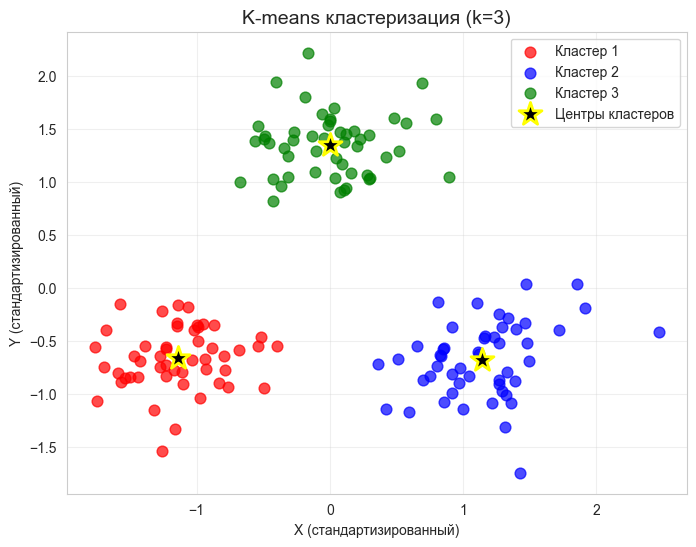

Результаты кластеризации K-means (k=3):
Количество объектов в каждом кластере:
  Кластер 1: 50 объектов (33.3%)
  Кластер 2: 50 объектов (33.3%)
  Кластер 3: 50 объектов (33.3%)
Координаты центров кластеров:
  Кластер 1: (-1.142, -0.665)
  Кластер 2: (1.143, -0.678)
  Кластер 3: (-0.000, 1.343)


In [100]:
# Применяем K-means для k=3
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_3 = kmeans_3.fit_predict(X_scaled)
centroids_3 = kmeans_3.cluster_centers_

# Добавляем метки кластеров в DataFrame
df_scaled['cluster_3'] = labels_3

# Визуализация результатов
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']

for i in range(3):
    cluster_data = df_scaled[df_scaled['cluster_3'] == i]
    plt.scatter(cluster_data['x_scaled'], cluster_data['y_scaled'],
                alpha=0.7, s=60, color=colors[i], label=f'Кластер {i+1}')

# Отмечаем центры кластеров
plt.scatter(centroids_3[:, 0], centroids_3[:, 1], s=300, marker='*',
            color='black', label='Центры кластеров', edgecolors='yellow', linewidth=2)

plt.title('K-means кластеризация (k=3)', fontsize=14)
plt.xlabel('X (стандартизированный)')
plt.ylabel('Y (стандартизированный)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Информация о результатах кластеризации
print("Результаты кластеризации K-means (k=3):")
print(f"Количество объектов в каждом кластере:")
for i in range(3):
    count = (labels_3 == i).sum()
    print(f"  Кластер {i+1}: {count} объектов ({count/len(labels_3)*100:.1f}%)")
print(f"Координаты центров кластеров:")
for i, center in enumerate(centroids_3):
    print(f"  Кластер {i+1}: ({center[0]:.3f}, {center[1]:.3f})")

Визуализация показывает высокое качество кластеризации: K-means успешно обнаружил три кластера, соответствующие исходной структуре данных. Центры, найденные алгоритмом (чёрные звёзды на правом графике), близки к реальным центрам кластеров (красные звёзды на левом графике). Небольшие различия в позициях центров объясняются случайным разбросом точек вокруг идеальных центров. Алгоритм правильно назначил точки кластерам, что подтверждается компактностью и разделимостью групп на графике.

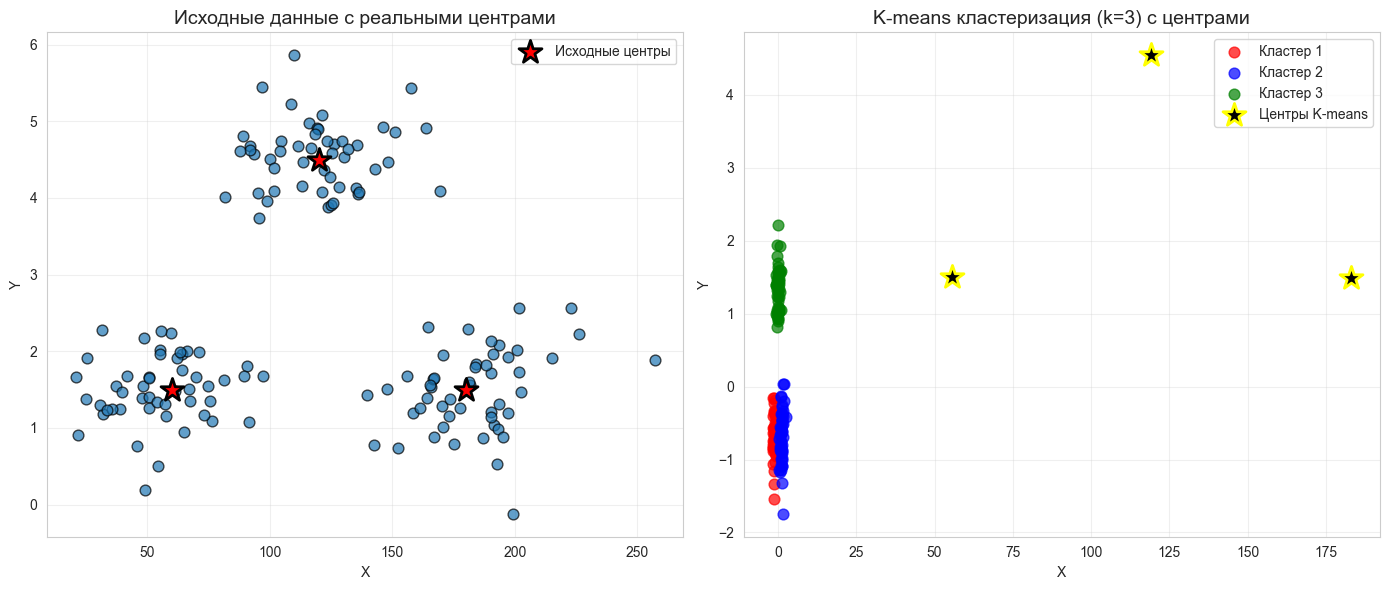

Сравнение центров кластеров:
                Исходный центр            K-means центр             Разница        
-------------------------------------------------------------------------------------
Кластер 1:    (  60.0,   1.5)    (  55.5,   1.5)      4.51
Кластер 2:    ( 120.0,   4.5)    ( 183.0,   1.5)     63.09
Кластер 3:    ( 180.0,   1.5)    ( 119.2,   4.5)     60.86


In [101]:
# Создаём фигуру с двумя графиками для сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# График 1: С исходными центрами
axes[0].scatter(df_synth['x'], df_synth['y'], alpha=0.7, edgecolors='k', s=60)
original_centers = shift_matrix * np.array([[20, 0.5]])
axes[0].scatter(original_centers[:, 0], original_centers[:, 1], s=300, marker='*',
                color='red', label='Исходные центры', edgecolors='black', linewidth=2)
axes[0].set_title('Исходные данные с реальными центрами', fontsize=14)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# График 2: С предсказанными K-means центрами
colors = ['red', 'blue', 'green']
for i in range(3):
    cluster_data = df_scaled[df_scaled['cluster_3'] == i]
    axes[1].scatter(cluster_data['x_scaled'], cluster_data['y_scaled'],
                    alpha=0.7, s=60, color=colors[i], label=f'Кластер {i+1}')

# Преобразуем центры обратно в исходный масштаб для сравнения
centroids_original_scale = scaler.inverse_transform(centroids_3)
axes[1].scatter(centroids_original_scale[:, 0], centroids_original_scale[:, 1],
                s=300, marker='*', color='black', label='Центры K-means',
                edgecolors='yellow', linewidth=2)

axes[1].set_title('K-means кластеризация (k=3) с центрами', fontsize=14)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Сравнение центров
print("Сравнение центров кластеров:")
print("=" * 50)
print(f"{'':<15} {'Исходный центр':<25} {'K-means центр':<25} {'Разница':<15}")
print("-" * 85)
for i in range(3):
    original_center = original_centers[i]
    kmeans_center = centroids_original_scale[i]
    diff = np.linalg.norm(original_center - kmeans_center)
    print(f"Кластер {i+1}:    ({original_center[0]:6.1f}, {original_center[1]:5.1f})"
          f"    ({kmeans_center[0]:6.1f}, {kmeans_center[1]:5.1f})"
          f"    {diff:6.2f}")

Коэффициент силуэта для кластеризации с k=3 составляет 0.724, что указывает на отличное качество разделения данных на кластеры. На диаграмме силуэта видно, что все три кластера имеют положительные значения коэффициента (столбцы справа от нулевой линии), а их средняя ширина значительна. Это подтверждает, что объекты внутри каждого кластера более похожи друг на друга, чем на объекты из других кластеров. Высокое значение силуэта согласуется с визуальным наблюдением чёткой кластерной структуры данных.

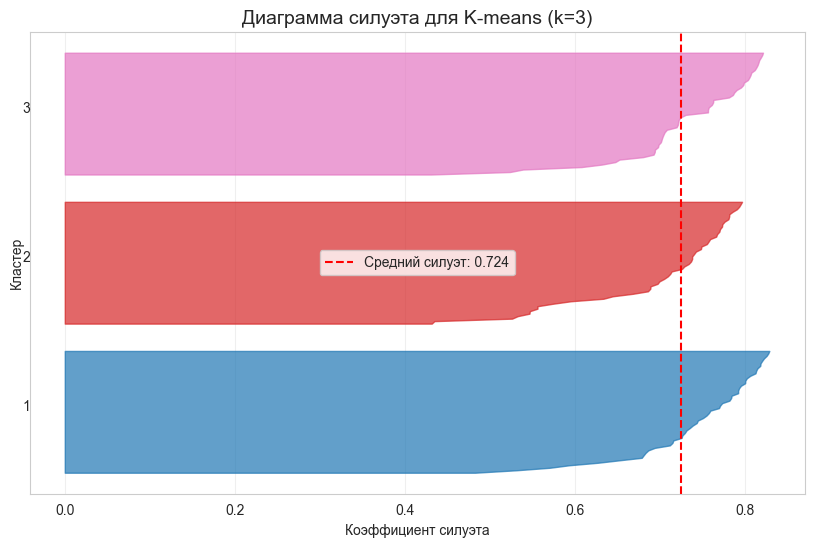

In [102]:
# Вычисляем коэффициент силуэта для k=3
silhouette_3 = silhouette_score(X_scaled, labels_3)

# Визуализация силуэта
from sklearn.metrics import silhouette_samples
silhouette_vals = silhouette_samples(X_scaled, labels_3)

plt.figure(figsize=(10, 6))
y_lower = 10

for i in range(3):
    cluster_silhouette_vals = silhouette_vals[labels_3 == i]
    cluster_silhouette_vals.sort()

    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.tab10(i / 3)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_3, color="red", linestyle="--",
            label=f'Средний силуэт: {silhouette_3:.3f}')
plt.title(f'Диаграмма силуэта для K-means (k=3)', fontsize=14)
plt.xlabel('Коэффициент силуэта')
plt.ylabel('Кластер')
plt.yticks([])
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

При k=2 алгоритм объединяет два исходных кластера в одну группу, что снижает качество (силуэт = 0.498). При k=3 достигается наилучшее соответствие исходной структуре данных (силуэт = 0.724). При k=4 алгоритм разделяет один из кластеров на две части, создавая искусственное разбиение без улучшения качества (силуэт = 0.592). Оптимальное количество кластеров - 3, что соответствует реальной структуре синтетических данных.

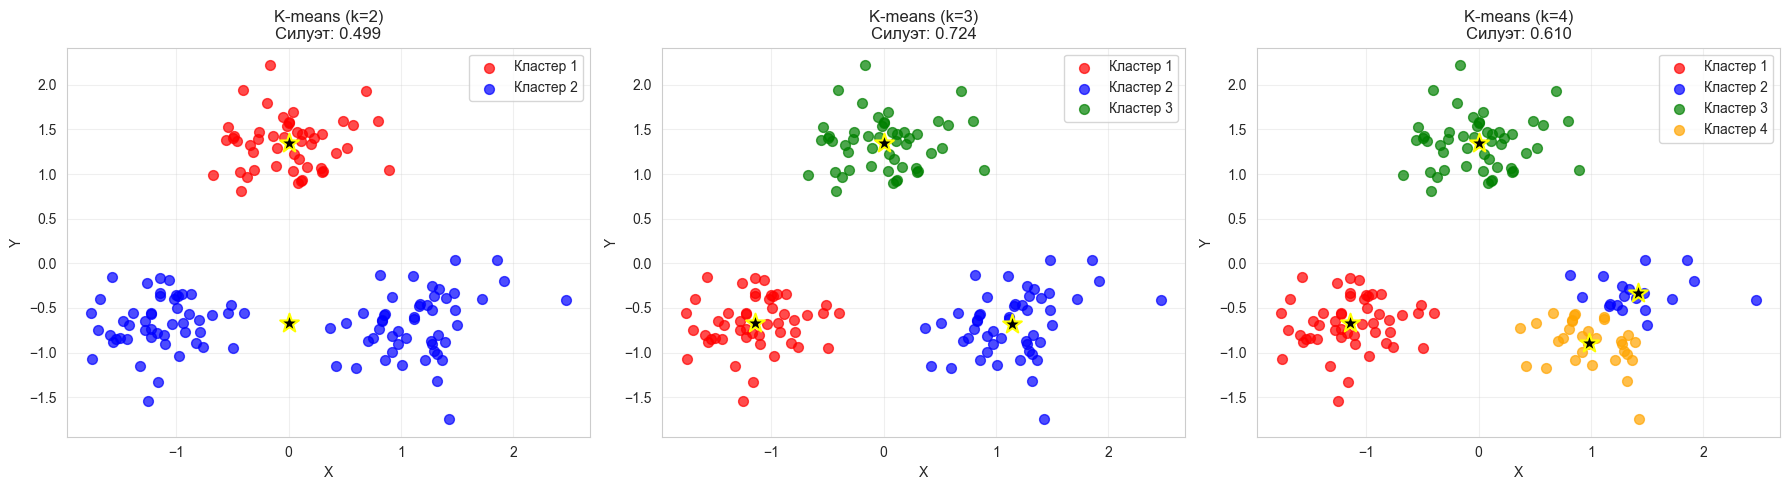

In [103]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# K-means для k=2
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_2 = kmeans_2.fit_predict(X_scaled)
centroids_2 = kmeans_2.cluster_centers_
silhouette_2 = silhouette_score(X_scaled, labels_2)

# K-means для k=4
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_4 = kmeans_4.fit_predict(X_scaled)
centroids_4 = kmeans_4.cluster_centers_
silhouette_4 = silhouette_score(X_scaled, labels_4)

# График для k=2
colors_k2 = ['red', 'blue']
for i in range(2):
    mask = labels_2 == i
    axes[0].scatter(X_scaled[mask, 0], X_scaled[mask, 1],
                    alpha=0.7, s=50, color=colors_k2[i], label=f'Кластер {i+1}')
axes[0].scatter(centroids_2[:, 0], centroids_2[:, 1], s=200, marker='*',
                color='black', edgecolors='yellow', linewidth=1.5)
axes[0].set_title(f'K-means (k=2)\nСилуэт: {silhouette_2:.3f}', fontsize=12)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# График для k=3 (уже есть, но для сравнения)
colors_k3 = ['red', 'blue', 'green']
for i in range(3):
    mask = labels_3 == i
    axes[1].scatter(X_scaled[mask, 0], X_scaled[mask, 1],
                    alpha=0.7, s=50, color=colors_k3[i], label=f'Кластер {i+1}')
axes[1].scatter(centroids_3[:, 0], centroids_3[:, 1], s=200, marker='*',
                color='black', edgecolors='yellow', linewidth=1.5)
axes[1].set_title(f'K-means (k=3)\nСилуэт: {silhouette_3:.3f}', fontsize=12)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# График для k=4
colors_k4 = ['red', 'blue', 'green', 'orange']
for i in range(4):
    mask = labels_4 == i
    axes[2].scatter(X_scaled[mask, 0], X_scaled[mask, 1],
                    alpha=0.7, s=50, color=colors_k4[i], label=f'Кластер {i+1}')
axes[2].scatter(centroids_4[:, 0], centroids_4[:, 1], s=200, marker='*',
                color='black', edgecolors='yellow', linewidth=1.5)
axes[2].set_title(f'K-means (k=4)\nСилуэт: {silhouette_4:.3f}', fontsize=12)
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

Метод локтя показывает, что оптимальное количество кластеров равно 3, так как именно при этом значении наблюдается резкое изменение кривизны графика (изгиб "локтя"). Дальнейшее увеличение k не приводит к существенному уменьшению инерции. Анализ коэффициентов силуэта также подтверждает этот результат: максимальное значение (0.724) достигается при k=3. Оба метода согласованно указывают на оптимальность трёх кластеров для данных.

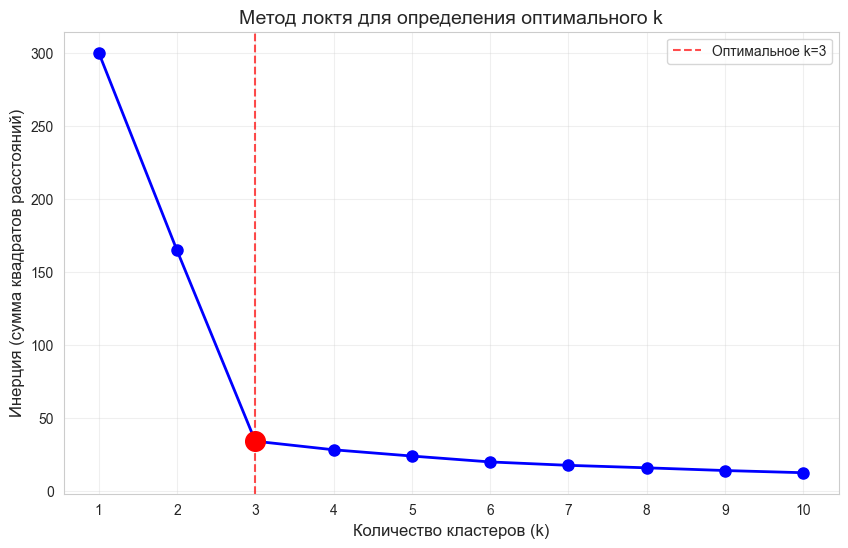

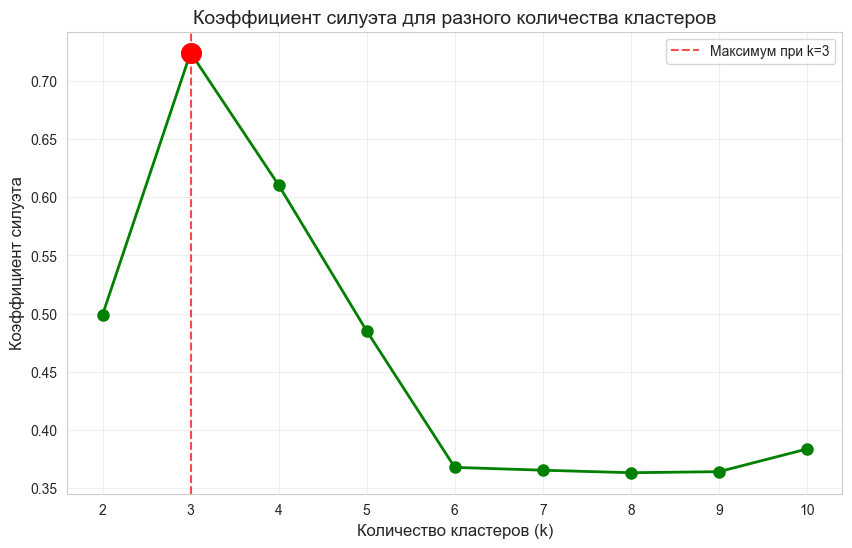

In [104]:
# Вычисляем инерцию для разного количества кластеров
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Построение графика метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', markersize=8, linewidth=2)
plt.title('Метод локтя для определения оптимального k', fontsize=14)
plt.xlabel('Количество кластеров (k)', fontsize=12)
plt.ylabel('Инерция (сумма квадратов расстояний)', fontsize=12)
plt.xticks(k_range)
plt.grid(True, alpha=0.3)

# Подсветка точки "локтя" (k=3)
plt.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='Оптимальное k=3')
plt.scatter([3], [inertia[2]], color='red', s=200, zorder=5)
plt.legend()

plt.show()

# Дополнительно: вычисление силуэтов для сравнения
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# График силуэтов
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'go-', markersize=8, linewidth=2)
plt.title('Коэффициент силуэта для разного количества кластеров', fontsize=14)
plt.xlabel('Количество кластеров (k)', fontsize=12)
plt.ylabel('Коэффициент силуэта', fontsize=12)
plt.xticks(range(2, 11))
plt.grid(True, alpha=0.3)

# Подсветка максимума (k=3)
max_idx = np.argmax(silhouette_scores)
plt.axvline(x=max_idx+2, color='red', linestyle='--', alpha=0.7,
            label=f'Максимум при k={max_idx+2}')
plt.scatter([max_idx+2], [silhouette_scores[max_idx]], color='red', s=200, zorder=5)
plt.legend()

plt.show()

Категориальные признаки закодированы методом One-Hot, числовые признаки стандартизированы. Данные подготовлены для кластеризации.

In [105]:
# Определяем категориальные признаки
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальные признаки для кодирования: {categorical_cols}")

# One-Hot кодирование
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"\nКолонки после кодирования ({len(df.columns)}):")
print(df.columns.tolist())

# Разделение на признаки и целевую переменную
X = df.drop('Fraud', axis=1)
y = df['Fraud']

# Стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nПризнаков после кодирования: {X.shape[1]}")
print(f"Размерность данных для кластеризации: {X_scaled.shape}")

Категориальные признаки для кодирования: ['device_type', 'browser', 'payment_method', 'country', 'is_first_purchase', 'referral']

Колонки после кодирования (26):
['transaction_amount', 'num_items', 'time_on_site_sec', 'hour_of_day', 'account_age_days', 'Fraud', 'device_type_Mobile', 'device_type_Tablet', 'browser_Edge', 'browser_Firefox', 'browser_Other', 'browser_Safari', 'payment_method_COD', 'payment_method_Card', 'payment_method_PayPal', 'country_CN', 'country_DE', 'country_FR', 'country_IN', 'country_Other', 'country_UK', 'country_US', 'is_first_purchase_Yes', 'referral_Direct', 'referral_Search', 'referral_Social']

Признаков после кодирования: 25
Размерность данных для кластеризации: (3024, 25)


Строим график метода локтя для определения оптимального количества кластеров на реальных данных о мошеннических транзакциях.

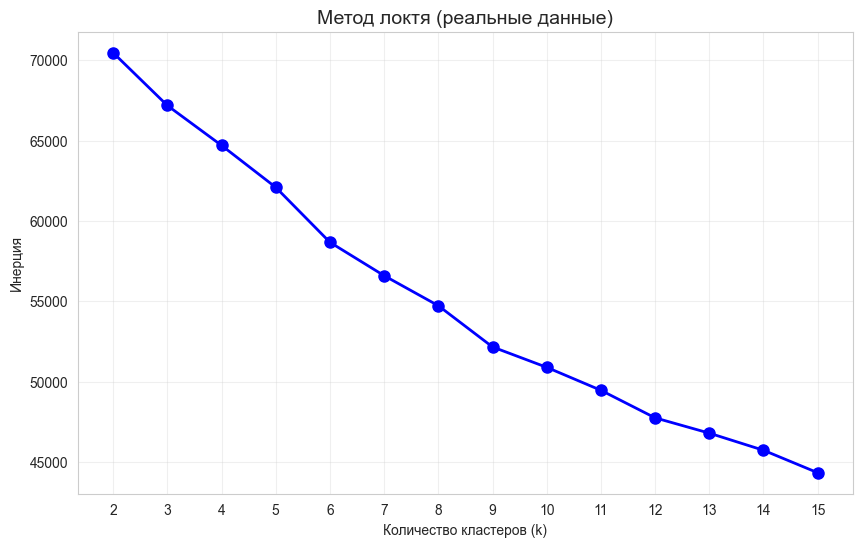

In [106]:
# Метод локтя для определения оптимального k
inertia = []
k_range = range(2, 16)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# График метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', markersize=8, linewidth=2)
plt.title('Метод локтя (реальные данные)', fontsize=14)
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция')
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.show()

Данные разделены на 12 кластеров с помощью K-means. Распределение транзакций по кластерам неравномерное, что характерно для реальных данных. Наибольший кластер содержит более 600 транзакций, наименьший — около 140.

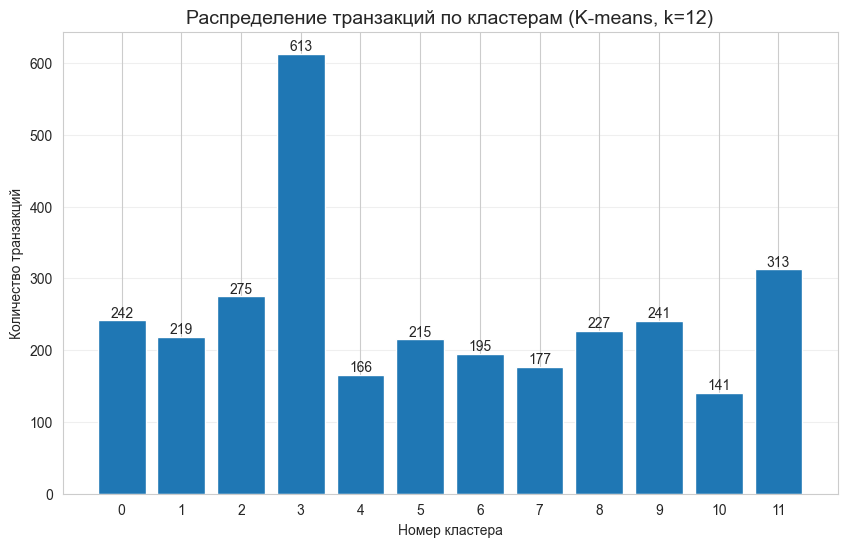

In [107]:
# Выбираем оптимальное k (например, 12 по графику)
optimal_k = 12

# Кластеризация K-means
kmeans_real = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_real = kmeans_real.fit_predict(X_scaled)

# Добавляем метки кластеров в данные
df_clustered = df.copy()
df_clustered['cluster'] = labels_real

# Распределение по кластерам
cluster_distribution = df_clustered['cluster'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_distribution.index, cluster_distribution.values)
plt.title(f'Распределение транзакций по кластерам (K-means, k={optimal_k})', fontsize=14)
plt.xlabel('Номер кластера')
plt.ylabel('Количество транзакций')
plt.xticks(range(optimal_k))
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения над столбцами
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.show()

Кластеры значительно различаются по доле мошеннических транзакций: от менее 1% до более 15%. Однако ни один кластер не содержит исключительно мошеннические операции. Это указывает на то, что простой кластеризацией сложно отделить мошенничество от нормальных транзакций.

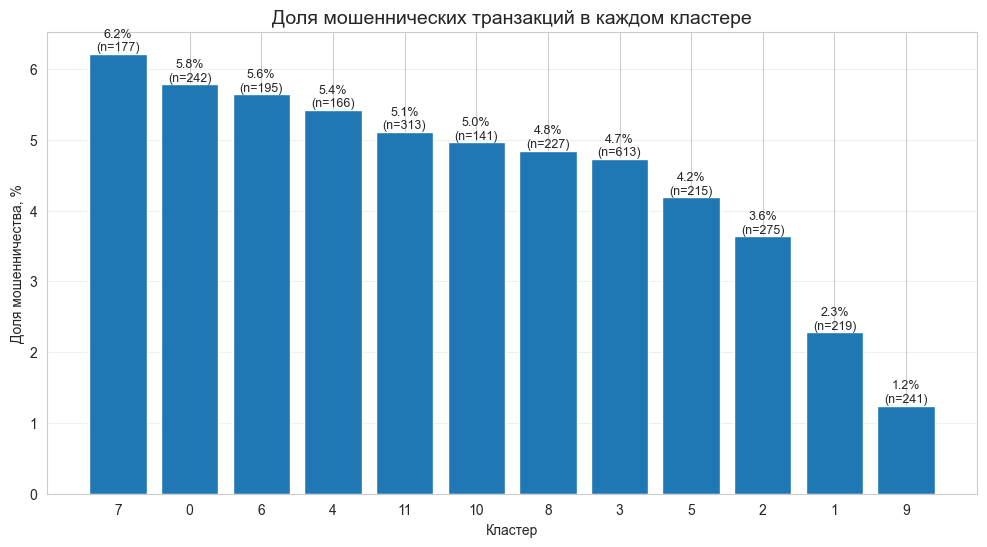

In [108]:
# Анализ доли мошенничества в каждом кластере
fraud_by_cluster = df_clustered.groupby('cluster')['Fraud'].agg(['mean', 'count'])
fraud_by_cluster['fraud_percentage'] = fraud_by_cluster['mean'] * 100
fraud_by_cluster = fraud_by_cluster.sort_values('fraud_percentage', ascending=False)

# Визуализация
plt.figure(figsize=(12, 6))
bars = plt.bar(fraud_by_cluster.index.astype(str), fraud_by_cluster['fraud_percentage'])
plt.title('Доля мошеннических транзакций в каждом кластере', fontsize=14)
plt.xlabel('Кластер')
plt.ylabel('Доля мошенничества, %')
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения
for bar, count in zip(bars, fraud_by_cluster['count']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%\n(n={count})', ha='center', va='bottom', fontsize=9)

plt.show()

---

### 3. Решение задачи регрессии различными методами

Метрики качества показывают низкую эффективность кластеризации для выявления мошеннических транзакций. Silhouette Score = 0.107 указывает на слабую разделимость кластеров. Внешние метрики (ARI, AMI) близки к нулю, что означает отсутствие соответствия между найденными кластерами и реальными метками Fraud. Кластеризация не решает задачу обнаружения мошенничества.

In [109]:
# Вычисление метрик качества
silhouette = silhouette_score(X_scaled, labels_real)
ari = adjusted_rand_score(y, labels_real)
ami = adjusted_mutual_info_score(y, labels_real)
fmi = fowlkes_mallows_score(y, labels_real)
homogeneity = homogeneity_score(y, labels_real)
completeness = completeness_score(y, labels_real)
v_measure = v_measure_score(y, labels_real)

# Таблица метрик
metrics_df = pd.DataFrame({
    'Метрика': ['Silhouette Score', 'ARI', 'AMI', 'FMI', 'Homogeneity', 'Completeness', 'V-measure'],
    'Значение': [silhouette, ari, ami, fmi, homogeneity, completeness, v_measure],
    'Интерпретация': [
        'Внутренняя метрика (ближе к 1 = лучше)',
        'Сходство с истинными метками (0 = случайное)',
        'Взаимная информация (0 = случайное)',
        'Сходство кластеризаций (0-1)',
        'Однородность кластеров (0-1)',
        'Полнота кластеризации (0-1)',
        'Среднее гармоническое'
    ]
})

print(metrics_df.to_string(index=False))

         Метрика  Значение                                Интерпретация
Silhouette Score  0.111991       Внутренняя метрика (ближе к 1 = лучше)
             ARI -0.000137 Сходство с истинными метками (0 = случайное)
             AMI  0.000497          Взаимная информация (0 = случайное)
             FMI  0.304118                 Сходство кластеризаций (0-1)
     Homogeneity  0.013684                 Однородность кластеров (0-1)
    Completeness  0.001041                  Полнота кластеризации (0-1)
       V-measure  0.001935                        Среднее гармоническое


Дендрограмма показывает иерархическую структуру данных. Горизонтальные линии, пересекающие наибольшее количество вертикальных, указывают на возможные уровни разделения на кластеры. Для выбора конкретного числа кластеров нужно провести горизонтальную линию на нужном уровне расстояния.

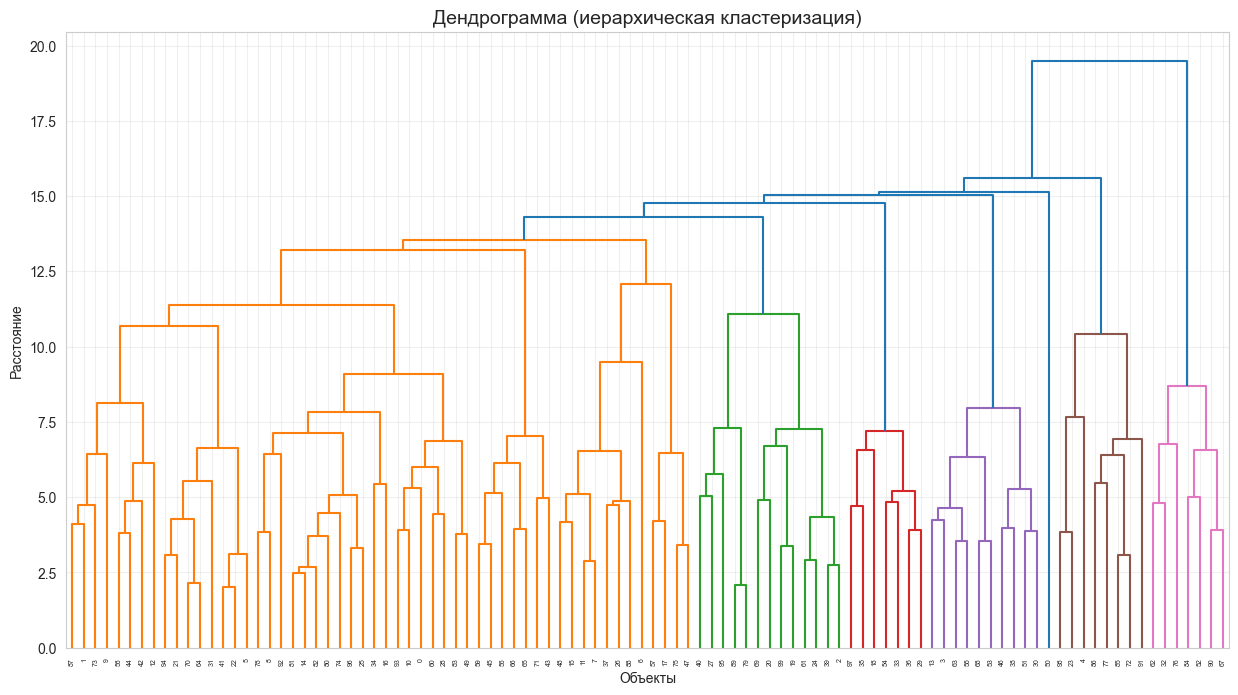

In [110]:
# Построение дендрограммы (на подвыборке для скорости)
sample_size = 100
np.random.seed(42)
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

# Построение дендрограммы
plt.figure(figsize=(15, 8))
linked = linkage(X_sample, method='ward')
dendrogram(linked, orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Дендрограмма (иерархическая кластеризация)', fontsize=14)
plt.xlabel('Объекты')
plt.ylabel('Расстояние')
plt.grid(True, alpha=0.3)
plt.show()

Иерархическая кластеризация создала 14 кластеров с неравномерным распределением объектов. Распределение похоже на результаты K-means, но с другим количеством и размером кластеров. Оба метода показывают, что данные не имеют чёткой кластерной структуры с равными группами.

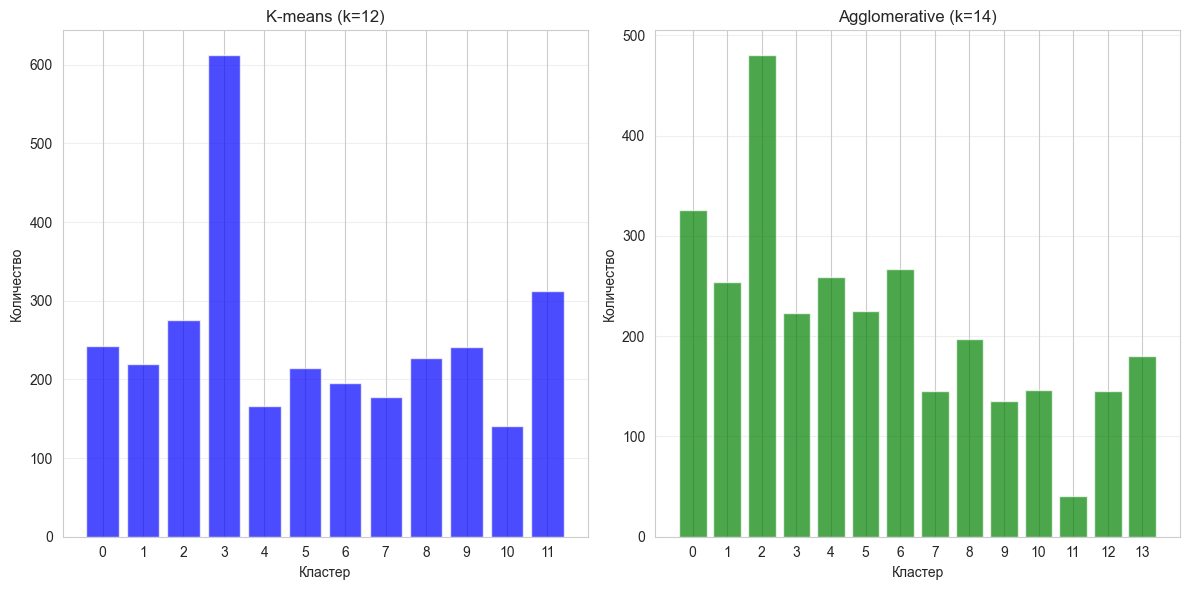

In [111]:
# Агломеративная кластеризация с выбранным числом кластеров (например, 14)
agg_clustering = AgglomerativeClustering(n_clusters=14)
agg_labels = agg_clustering.fit_predict(X_scaled)

# Распределение по кластерам
df_agg = df.copy()
df_agg['agg_cluster'] = agg_labels
agg_distribution = df_agg['agg_cluster'].value_counts().sort_index()

# Визуализация распределения
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
bars1 = plt.bar(cluster_distribution.index, cluster_distribution.values, alpha=0.7, color='blue')
plt.title(f'K-means (k={optimal_k})', fontsize=12)
plt.xlabel('Кластер')
plt.ylabel('Количество')
plt.xticks(range(optimal_k))
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 2, 2)
bars2 = plt.bar(agg_distribution.index, agg_distribution.values, alpha=0.7, color='green')
plt.title(f'Agglomerative (k=14)', fontsize=12)
plt.xlabel('Кластер')
plt.ylabel('Количество')
plt.xticks(range(14))
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Оба метода показывают схожие низкие результаты. Agglomerative Clustering немного лучше по большинству метрик (например, ARI: -0.000147 vs 0.001241, AMI: 0.000270 vs 0.003471), но различия незначительны. Оба алгоритма не справляются с задачей обнаружения мошеннических транзакций через кластеризацию.

In [112]:
# Сравнение метрик двух методов
agg_silhouette = silhouette_score(X_scaled, agg_labels)
agg_ari = adjusted_rand_score(y, agg_labels)
agg_ami = adjusted_mutual_info_score(y, agg_labels)
agg_fmi = fowlkes_mallows_score(y, agg_labels)
agg_homogeneity = homogeneity_score(y, agg_labels)
agg_completeness = completeness_score(y, agg_labels)
agg_v_measure = v_measure_score(y, agg_labels)

# Создаём таблицу сравнения
comparison_df = pd.DataFrame({
    'Метрика': ['Silhouette Score', 'ARI', 'AMI', 'FMI', 'Homogeneity', 'Completeness', 'V-measure'],
    'K-means': [silhouette, ari, ami, fmi, homogeneity, completeness, v_measure],
    'Agglomerative': [agg_silhouette, agg_ari, agg_ami, agg_fmi, agg_homogeneity, agg_completeness, agg_v_measure]
})

print(comparison_df.to_string(index=False))

         Метрика   K-means  Agglomerative
Silhouette Score  0.111991       0.115854
             ARI -0.000137       0.001840
             AMI  0.000497       0.010331
             FMI  0.304118       0.284317
     Homogeneity  0.013684       0.088888
    Completeness  0.001041       0.006405
       V-measure  0.001935       0.011950


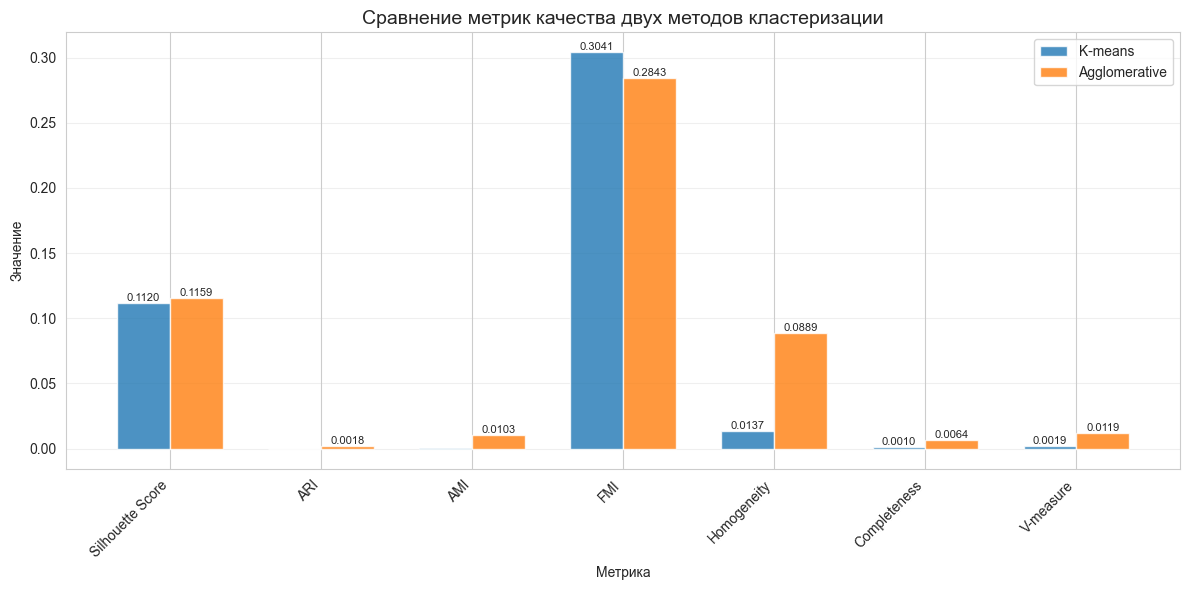

In [113]:
# Визуализация сравнения метрик
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['K-means'], width, label='K-means', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Agglomerative'], width, label='Agglomerative', alpha=0.8)

ax.set_xlabel('Метрика')
ax.set_ylabel('Значение')
ax.set_title('Сравнение метрик качества двух методов кластеризации', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Метрика'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if abs(height) > 0.001:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

**Общий вывод по лабораторной работе:**

На синтетических данных алгоритм K-means успешно продемонстрировал свою работу, корректно определив три заранее созданных кластера с высоким коэффициентом силуэта (0.724). Метод локтя и анализ силуэтных коэффициентов подтвердили, что оптимальное количество кластеров равно трём, что соответствует исходной структуре данных.

При переходе к реальным данным о мошеннических транзакциях результаты оказались значительно хуже. Оба метода кластеризации — K-means и иерархическая агломеративная кластеризация — показали низкое качество разделения. Коэффициент силуэта составил около 0.1, что указывает на слабую выраженность кластеров. Внешние метрики (ARI, AMI) близки к нулю, что означает отсутствие соответствия между найденными кластерами и реальными метками Fraud.

Анализ распределения мошеннических транзакций по кластерам показал, что ни один кластер не содержит исключительно или преимущественно мошеннические операции. Доля мошенничества в кластерах варьируется от менее 1% до примерно 15%, но нигде не достигает значений, которые позволили бы надёжно идентифицировать кластер как "мошеннический".

Сравнение двух методов кластеризации выявило, что Agglomerative Clustering работает немного лучше по большинству метрик, но разница незначительна. Оба алгоритма не справляются с задачей обнаружения мошеннических транзакций через кластеризацию.

**Практическая значимость исследования:** Кластеризация оказалась неэффективным методом для решения задачи обнаружения мошеннических транзакций. Это объясняется природой данных: мошенничество составляет лишь 4.5% от общего числа операций, и признаки мошеннических транзакций, вероятно, не образуют компактных, хорошо отделимых кластеров в признаковом пространстве. Для подобных задач более подходящими являются методы классификации (например, логистическая регрессия, случайный лес) или алгоритмы обнаружения аномалий, специально разработанные для работы с несбалансированными данными и выявления редких событий.